In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from BondingCurveNexus.sys_class import NexusSystem
from scipy.stats import lognorm
from tqdm import tqdm

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1279.09

In [3]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2924509.0234178

# Dutch Auction Modelling

## Reverse Dutch Auction Mechanism - Below Book

At launch, exit price = wnxm price (or slightly below)

2 Mechanisms:
1. Uniswap v2 Curve to push price down when sales happen
2. Slow increase in system price over time

Ceiling at book value - we don't want to allow people to sell for more than BV.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
In the long term should tend towards book value as liquidity at lower levels is drained.

### Initial Liquidity

40% is commited to investments and 10% can be treated as a buffer for claims, so let's assume we have ~50% of the capital pool to play with - define this as free_capital_perc.

We probably don't want to use all of it (need buffer for writing new covers etc.), so we can define another percentage for actual liquidity allocation to the notional uni curve, call this liq_alloc_perc.

We then use a formula to derive the initial liquidity of the ETH pool, with liq_alloc_perc as an input that can be varied.

In [7]:
free_capital_perc = 0.5
free_capital = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).cap_pool * free_capital_perc

def open_liq(liq_alloc_perc):
    return liq_alloc_perc * free_capital

opening_liquidity_eth = open_liq(0.5)
opening_liquidity_eth

38397.5

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two. Rounded to nearest 10k (last 23/08/2022)

In [8]:
def wnxm_movement_per_eth(two_perc_liq_usd):
    
    # find amount of ETH that it would take to move wNXM price 2%, given USD amount input
    two_perc_liq_eth = two_perc_liq_usd/eth_price_usd
    
    # calculate the size of a 2% movement in terms of wNXM price in ETH
    two_perc_nxm_movement = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).wnxm_price * 0.02
    
    # output wNXM price movement in ETH per 1 ETH worth of wNXM bought on open market
    return two_perc_nxm_movement / two_perc_liq_eth

In [9]:
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
wnxm_move_size

5.92692956572e-07

In [10]:
# How a wNXM buy works:
# establish current price
wnxm_open_price = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).wnxm_price
# establish number of wNXM bought
n_wnxm = 50000
# translate amount to ETH
n_eth = n_wnxm * wnxm_open_price
# establish closing price
wnxm_close_price = wnxm_open_price + n_eth * wnxm_movement_per_eth(250_000)
print(wnxm_open_price, n_eth, wnxm_close_price, wnxm_close_price/wnxm_open_price - 1)

0.01158427 579.2135000000001 0.012270861523602832 0.05926929565719985


### NXM sell sizing - Lognormal

lognormal distribution of size of a typical entry and exit in ETH
parameterised to median value being ~1 ETH, upper quartile ~4-5 ETH

In [11]:
exit_shape = 2
exit_loc = 0
exit_scale = 1

In [12]:
pd.DataFrame(lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale, size=1000)).describe()

,0
count,1000.000000
mean,7.983507
std,34.121096
min,0.001199
25%,0.283157
50%,1.179519
75%,3.947069
max,729.267229


### Ratchet sizing

Increase system NXM price by 0.5% per day, initially by just decreasing NXM quantity in pool

In [13]:
ratchet_perc = 0.005

### Uniswap v2 OOP Class

In [19]:
# Create class with initial liquidity parameters

class UniPool:
    # initial parameters
    def __init__(self, liquidity_eth):
        # start at day 0
        self.current_day = 0
        
        # initial wNXM price, wNXM and NXM supply, Capital Pool
        self.wnxm_price = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).wnxm_price
        self.nxm_supply = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).nxm_supply
        self.wnxm_supply = wnxm_supply_now
        self.cap_pool = NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).cap_pool
        
        # set initial ETH liquidity
        self.liquidity_eth = liquidity_eth
        
        # set initial NXM liquidity based on opening wnxm price
        # in practice we can start much lower than wnxm price (as we won't necessarily have an oracle)
        # but for simulation purposes this is the first interesting point
        self.liquidity_nxm = self.liquidity_eth / NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).wnxm_price
        
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.nxm_burned = 0
        self.wnxm_removed = 0
        
        # set tracking lists for individual instance
        self.cap_pool_prediction = [self.cap_pool]
        self.nxm_price_prediction = [self.nxm_price()]
        self.wnxm_price_prediction = [self.wnxm_price]
        self.nxm_supply_prediction = [self.nxm_supply]
        self.wnxm_supply_prediction = [self.wnxm_supply]
        self.book_value_prediction = [self.book_value()]
        self.liquidity_nxm_prediction = [self.liquidity_nxm]
        self.liquidity_eth_prediction = [self.liquidity_eth]
        self.eth_sold_prediction = [self.eth_sold]
        self.nxm_burned_prediction = [self.nxm_burned]
        self.wnxm_removed_prediction = [self.wnxm_removed]
        
        
    # system nxm price expressed in ETH
    def book_value(self):
        if self.nxm_supply == 0:
            return 0
        return self.cap_pool/self.nxm_supply
    
    def nxm_price(self):
        return self.liquidity_eth / self.liquidity_nxm
    
    def nxm_sale_size(self):
        return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale)
        
    # one sale of n_nxm NXM
    def platform_nxm_sale(self, n_nxm):
        # limit number to total NXM
        n_nxm = min(n_nxm, self.nxm_supply)
        
        # add sold NXM to pool
        self.liquidity_nxm += n_nxm
        self.nxm_supply -= n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        
        # add ETH removed and nxm burned to cumulative total, update capital pool
        self.eth_sold += self.liquidity_eth - new_eth
        self.cap_pool -= self.liquidity_eth - new_eth
        self.nxm_burned += n_nxm
        
        # update ETH liquidity
        self.liquidity_eth = new_eth
    
    def wnxm_market_buy(self, n_wnxm, arb=True):
        # limit number of wnxm bought to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount obtained (assuming whole buy happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # increase price depending on defined liquidity parameters
        self.wnxm_price += n_eth * wnxm_move_size
        
        # if used for arb, remove from supply
        if arb:
            self.wnxm_supply -= n_wnxm
            self.wnxm_removed += n_wnxm
    
    def arb_sale_transaction(self):
        num = self.nxm_sale_size()
        self.wnxm_market_buy(num, arb=True)
        self.platform_nxm_sale(num)
        
    def ratchet(self, num, kind='nxm'):
        if self.book_value() > self.nxm_price():
            if kind == 'nxm':
                self.liquidity_nxm -= num
            elif kind == 'eth':
                self.liquidity_eth += num

            self.invariant = self.liquidity_eth * self.liquidity_nxm
    
    def one_day_passes(self):
        # ratchet price
        self.ratchet(num=ratchet_perc*self.liquidity_nxm, kind='nxm')
        # arbitrage sales
        while self.nxm_price() > self.wnxm_price:
            self.arb_sale_transaction()
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price())
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        
        # increment day
        self.current_day += 1

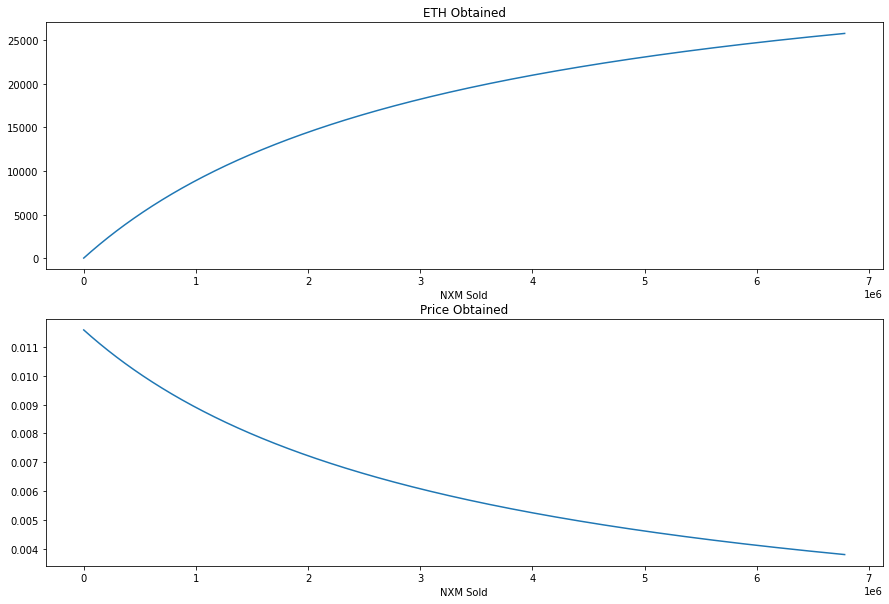

In [20]:
# sale size vs ETH and Price obtained 
sale_sizes = np.linspace(100, NexusSystem(liquidity_eth=30_000, wnxm_move_size=0.00001).nxm_supply, 1000)
eth_obtained = []
nxm_prices_obtained = []

for n_nxm in sale_sizes:
    sim = UniPool(opening_liquidity_eth)
    sim.platform_nxm_sale(n_nxm)
    eth_obtained.append(sim.eth_sold)
    nxm_prices_obtained.append(sim.eth_sold / n_nxm)
    
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(sale_sizes, eth_obtained)
axs[0].set_title('ETH Obtained')
axs[0].set_xlabel('NXM Sold')
axs[1].plot(sale_sizes, nxm_prices_obtained)
axs[1].set_title('Price Obtained')
axs[1].set_xlabel('NXM Sold');

## Below BV - Simulation & Range Tests

### Set up Single Simulation

In [22]:
model_days = 366

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:08<00:00, 44.85it/s]


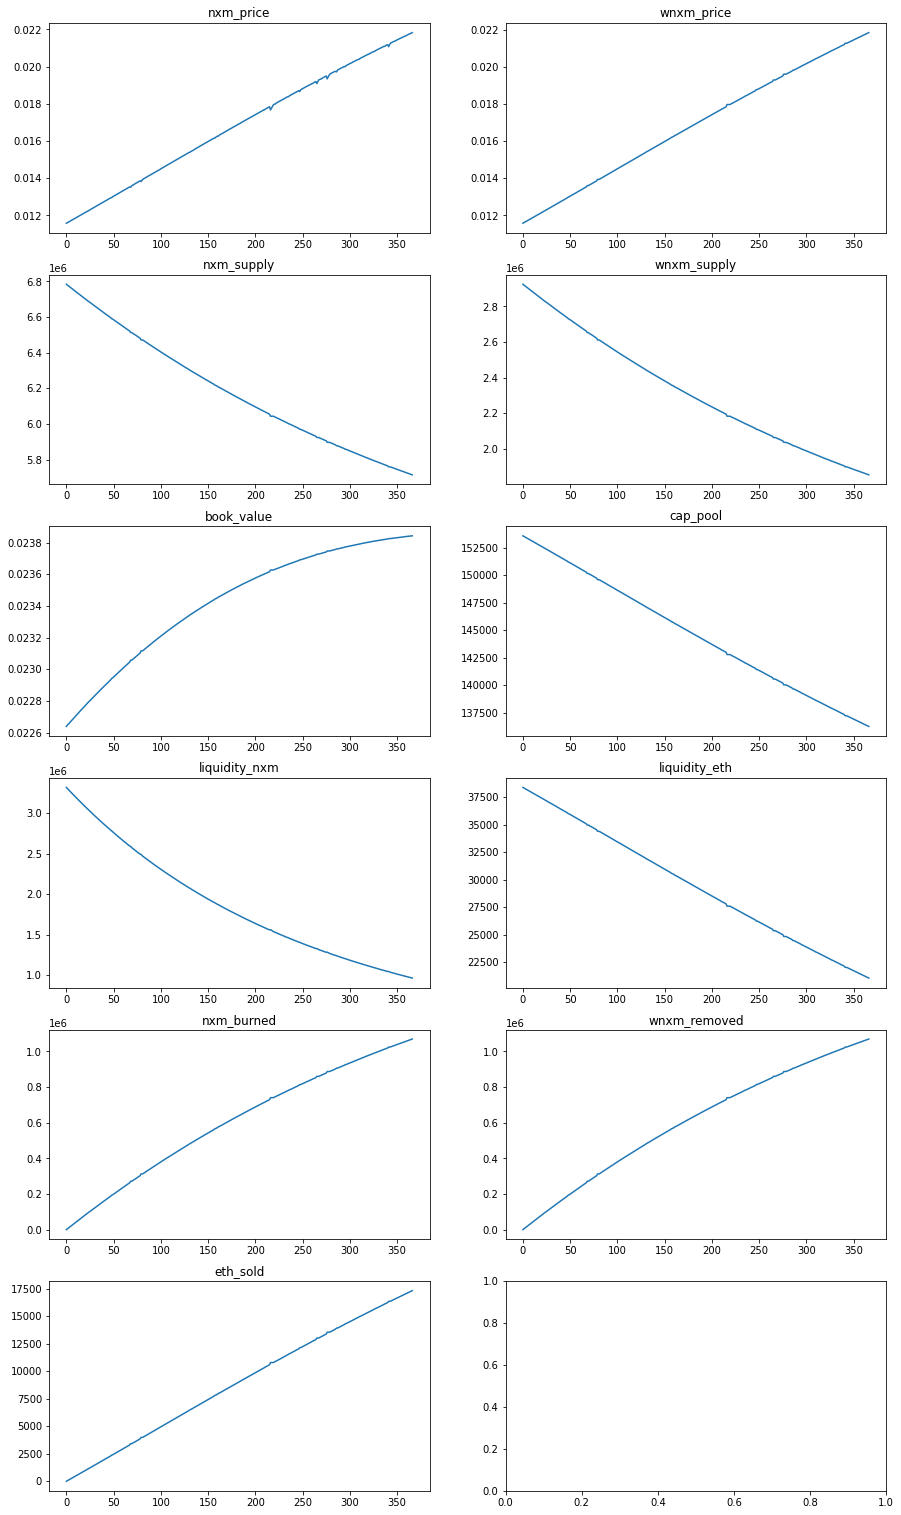

In [23]:
ratchet_perc = 0.005
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
opening_liquidity_eth = open_liq(0.5)

sim = UniPool(opening_liquidity_eth)

for i in tqdm(range(model_days)):
    sim.one_day_passes()
    
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(6, 2, figsize=(15,27)) # axs is a (6,2) nd-array

# Subplot
axs[0, 0].plot(range(model_days+1), sim.nxm_price_prediction)
axs[0, 0].set_title('nxm_price')
# Subplot
axs[0, 1].plot(range(model_days+1), sim.wnxm_price_prediction)
axs[0, 1].set_title('wnxm_price')
# Subplot
axs[1, 0].plot(range(model_days+1), sim.nxm_supply_prediction)
axs[1, 0].set_title('nxm_supply')
# Subplot
axs[1, 1].plot(range(model_days+1), sim.wnxm_supply_prediction)
axs[1, 1].set_title('wnxm_supply')
# Subplot
axs[2, 0].plot(range(model_days+1), sim.book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot
axs[2, 1].plot(range(model_days+1), sim.cap_pool_prediction)
axs[2, 1].set_title('cap_pool')
# Subplot
axs[3, 0].plot(range(model_days+1), sim.liquidity_nxm_prediction)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].plot(range(model_days+1), sim.liquidity_eth_prediction)
axs[3, 1].set_title('liquidity_eth')
# Subplot
axs[4, 0].plot(range(model_days+1), sim.nxm_burned_prediction)
axs[4, 0].set_title('nxm_burned')
# Subplot
axs[4, 1].plot(range(model_days+1), sim.wnxm_removed_prediction)
axs[4, 1].set_title('wnxm_removed')
# Subplot
axs[5, 0].plot(range(model_days+1), sim.eth_sold_prediction)
axs[5, 0].set_title('eth_sold')

plt.show()

### NXM Supply decrease rate

We provide a range by which the ratcheting mechanism drives up the wNXM price.

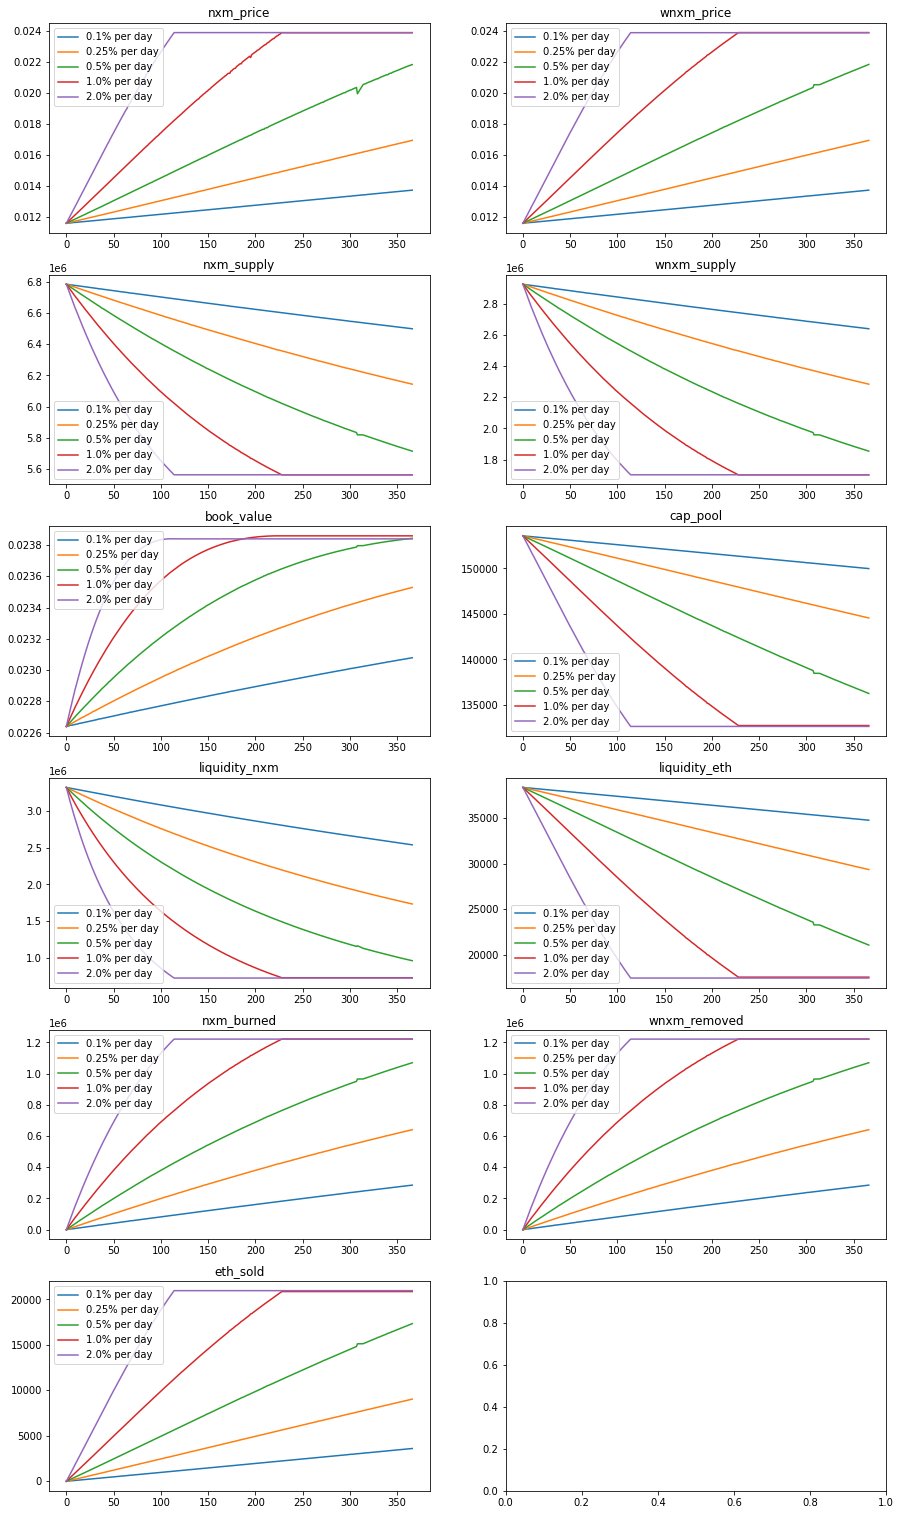

In [24]:
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
opening_liquidity_eth = open_liq(0.5)

ratchet_perc_options = [0.001, 0.0025, 0.005, 0.01, 0.02]

sims = [UniPool(opening_liquidity_eth) for x in range(len(ratchet_perc_options))]
for n, sim in enumerate(sims):
    ratchet_perc = ratchet_perc_options[n]
    for i in range(model_days):
        sim.one_day_passes()

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(6, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[4, 1].set_title('wnxm_removed')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()

#plt.suptitle('Ratchet speed values')
plt.show()

This would get the price up to book value in about a year, assuming 500k USD of liquidity in open wNXM markets per 2% change relative to current price.

**Use in other range tests** - 0.5% decrease in virtual pool wNXM supply per day. 

### wNXM liquidity in markets

We test a range of available wNXM liquidity in markets. At current prices, according to coingecko, a 2% shift occurs approximately at $250k sold/bought. Likely that more market sellers will be available at higher prices, so most alternative liquidity parameter tests are explored upwards.

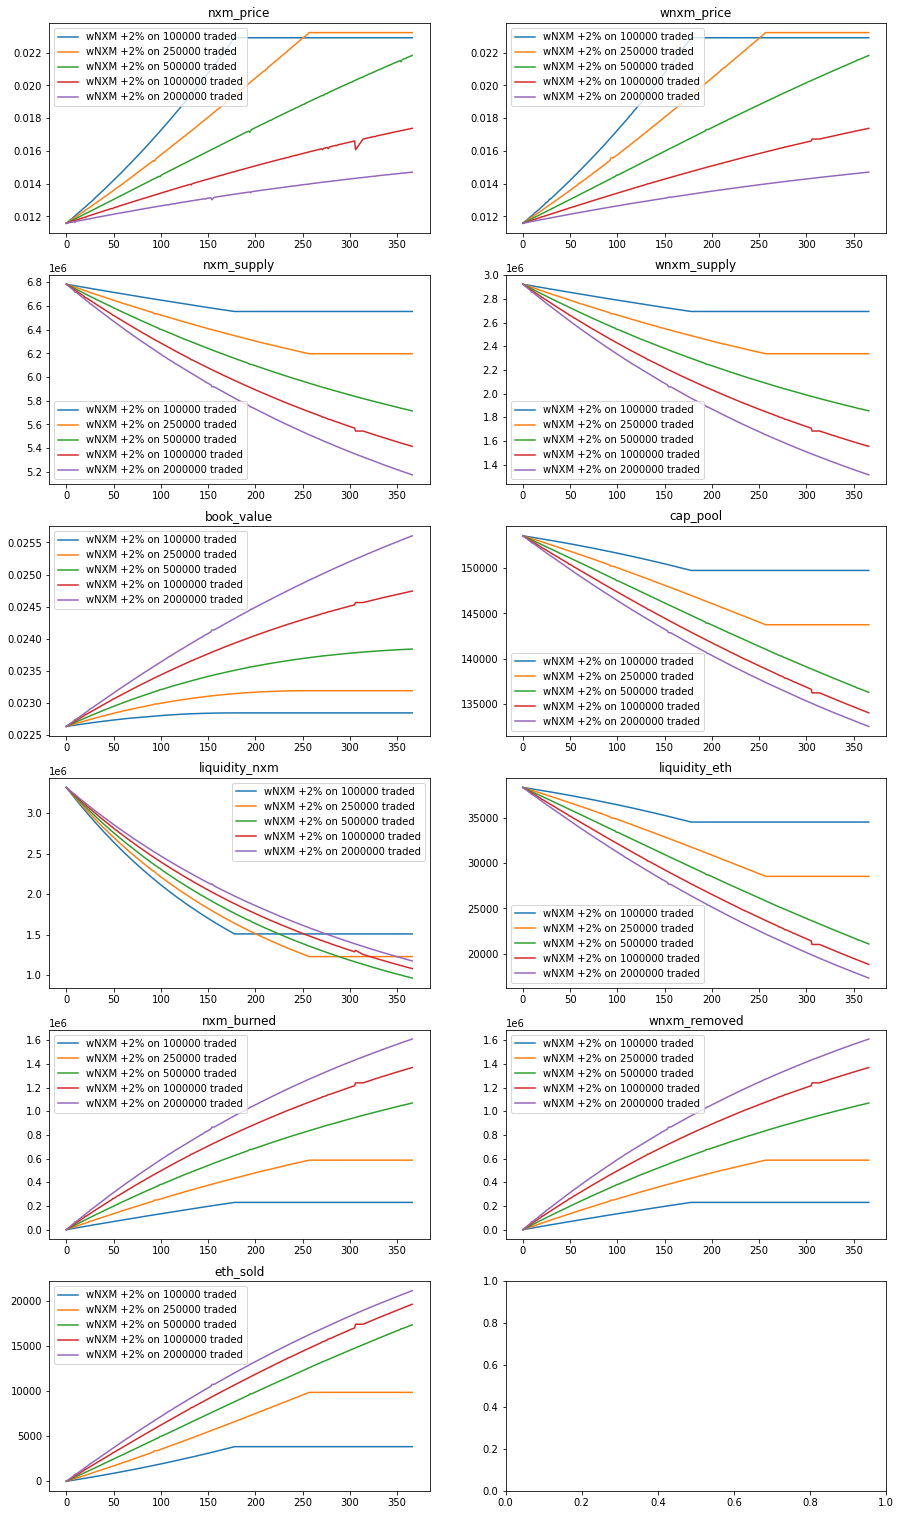

In [25]:
ratchet_perc = 0.005
opening_liquidity_eth = open_liq(0.5)

wnxm_liq_range_usd = [100_000, 250_000, 500_000, 1_000_000, 2_000_000]

sims = [UniPool(opening_liquidity_eth) for x in range(len(wnxm_liq_range_usd))]
for n, sim in enumerate(sims):
    wnxm_move_size = wnxm_movement_per_eth(wnxm_liq_range_usd[n])
    for i in range(model_days):
        sim.one_day_passes()

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(6, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 1].set_title('wnxm_removed')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()

plt.show()

At a certain level of market depth (about $1m per 2% increase in wNXM price), the book value is increased enough from arbitrage bots selling NXM to the platform below book value that the ratchet price at 0.5% per day doesn't catch up to book value before almost all ETH liquidity is drained from the notional pool.

Suggest that, given the wNXM supply graph, it is unlikely that more than 1m wNXM will be sold through this mechanism, ruling out the 1m and 2m USD per 2 percent change depth.

However, it is unlikely that as wNXM price rises toward book value, there will not be more sellers than there are currently, so 500k per 2 percent change relative to current wNXM/ETH price is a reasonable compromise.

**Use for other range tests:** 500k USD shifts the wNXM price by _current wNXM price in ETH * 0.02_

### Change in initial ETH supply

Test whether there is much impact in terms of changing the initial supply of ETH that is provided to the liquidity pool.

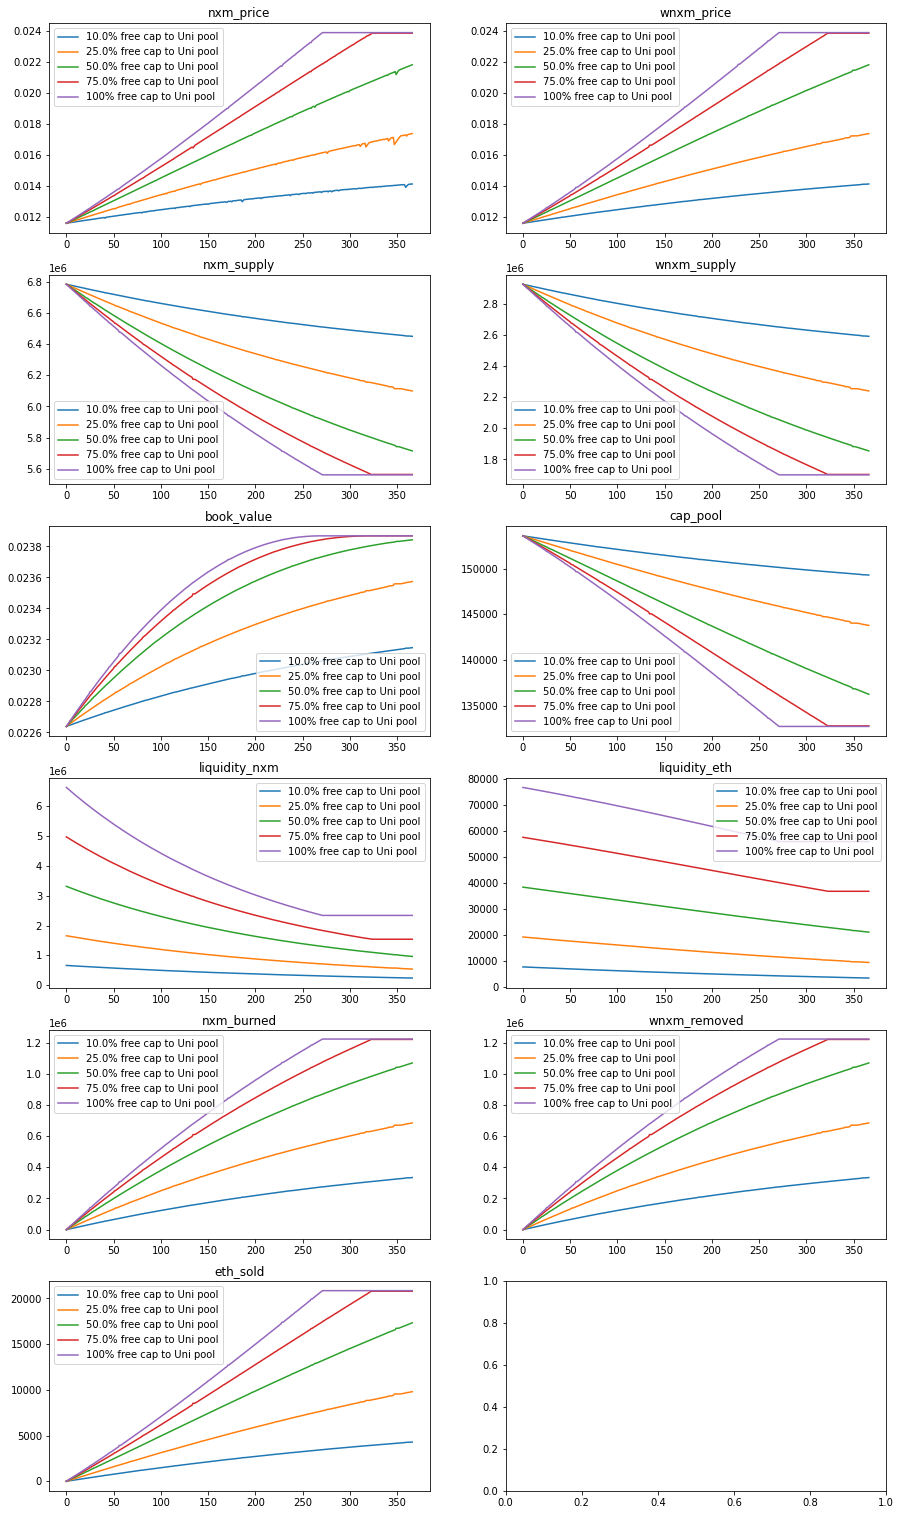

In [26]:
ratchet_perc = 0.005
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)

liq_perc_range = [0.1, 0.25, 0.5, 0.75, 1]

sims = [UniPool(open_liq(x)) for x in liq_perc_range]
for sim in sims:
    for i in range(model_days):
        sim.one_day_passes()

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(6, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[4, 1].set_title('wnxm_removed')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()

plt.show()

We can see that the more liquidity we provide:
- The more quickly NXM gets sold for ETH to the pool.
- This also drives up the book value quicker.

Less intuitively:
- The NXM price, and hence, wNXM price goes up quicker the more liquidity we provide in ETH.

This is a result of the following:
- The limit of how many wNXM get bought & then sold as NXM through the system is driven by available market liquidity for wNXM before the arbitrage opportunity is gone, not system ETH supply.
- Hence, there is a lower price impact downwards in between each ratchet step, while the ratchet size remains unchanged at 1%. The 1% increase each time is applied to a bigger price number when there is more ETH liquidity.  

**Use for other range tests**: 50% of available ETH liquidity, so ~34.5k ETH